In [1]:
# !pip install yfinance
import yfinance as yf
import numpy as np
import numpy as np
from gtda.time_series import SlidingWindow
from gtda.diagrams import PersistenceLandscape
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

# !pip install spectrum 
#from spectrum.periodogram import speriodogram

In [2]:
data = yf.download("^GSPC ^DJI ^IXIC ^RUT", start="1987-12-23")
data = data['Adj Close'].reset_index()
# Removing nulls from dji
data = data[data['^DJI'].notna()]
data['Date'] = pd.to_datetime(data['Date'])
df = data

[*********************100%***********************]  4 of 4 completed


In [3]:
data.head()

,Date,^DJI,^GSPC,^IXIC,^RUT
1017,1992-01-02,3172.399902,417.260010,586.450012,188.750000
1018,1992-01-03,3201.500000,419.339996,592.650024,192.089996
1019,1992-01-06,3200.100098,417.959991,597.900024,194.330002
1020,1992-01-07,3204.800049,417.399994,602.289978,195.770004
1021,1992-01-08,3203.899902,418.100006,610.320007,198.080002


In [4]:
data.describe()

,^DJI,^GSPC,^IXIC,^RUT
count,7777.000000,7777.000000,7777.000000,7777.000000
mean,13524.239269,1567.351408,3721.189299,813.730611
std,8040.369279,974.639770,3373.768906,520.785423
min,3136.600098,394.500000,547.840027,185.809998
25%,8612.129883,970.280029,1649.469971,427.709991
50%,10923.549805,1282.729980,2404.350098,657.719971
75%,17138.199219,2002.160034,4712.529785,1154.150024
max,36799.648438,4796.560059,16057.440430,2442.739990


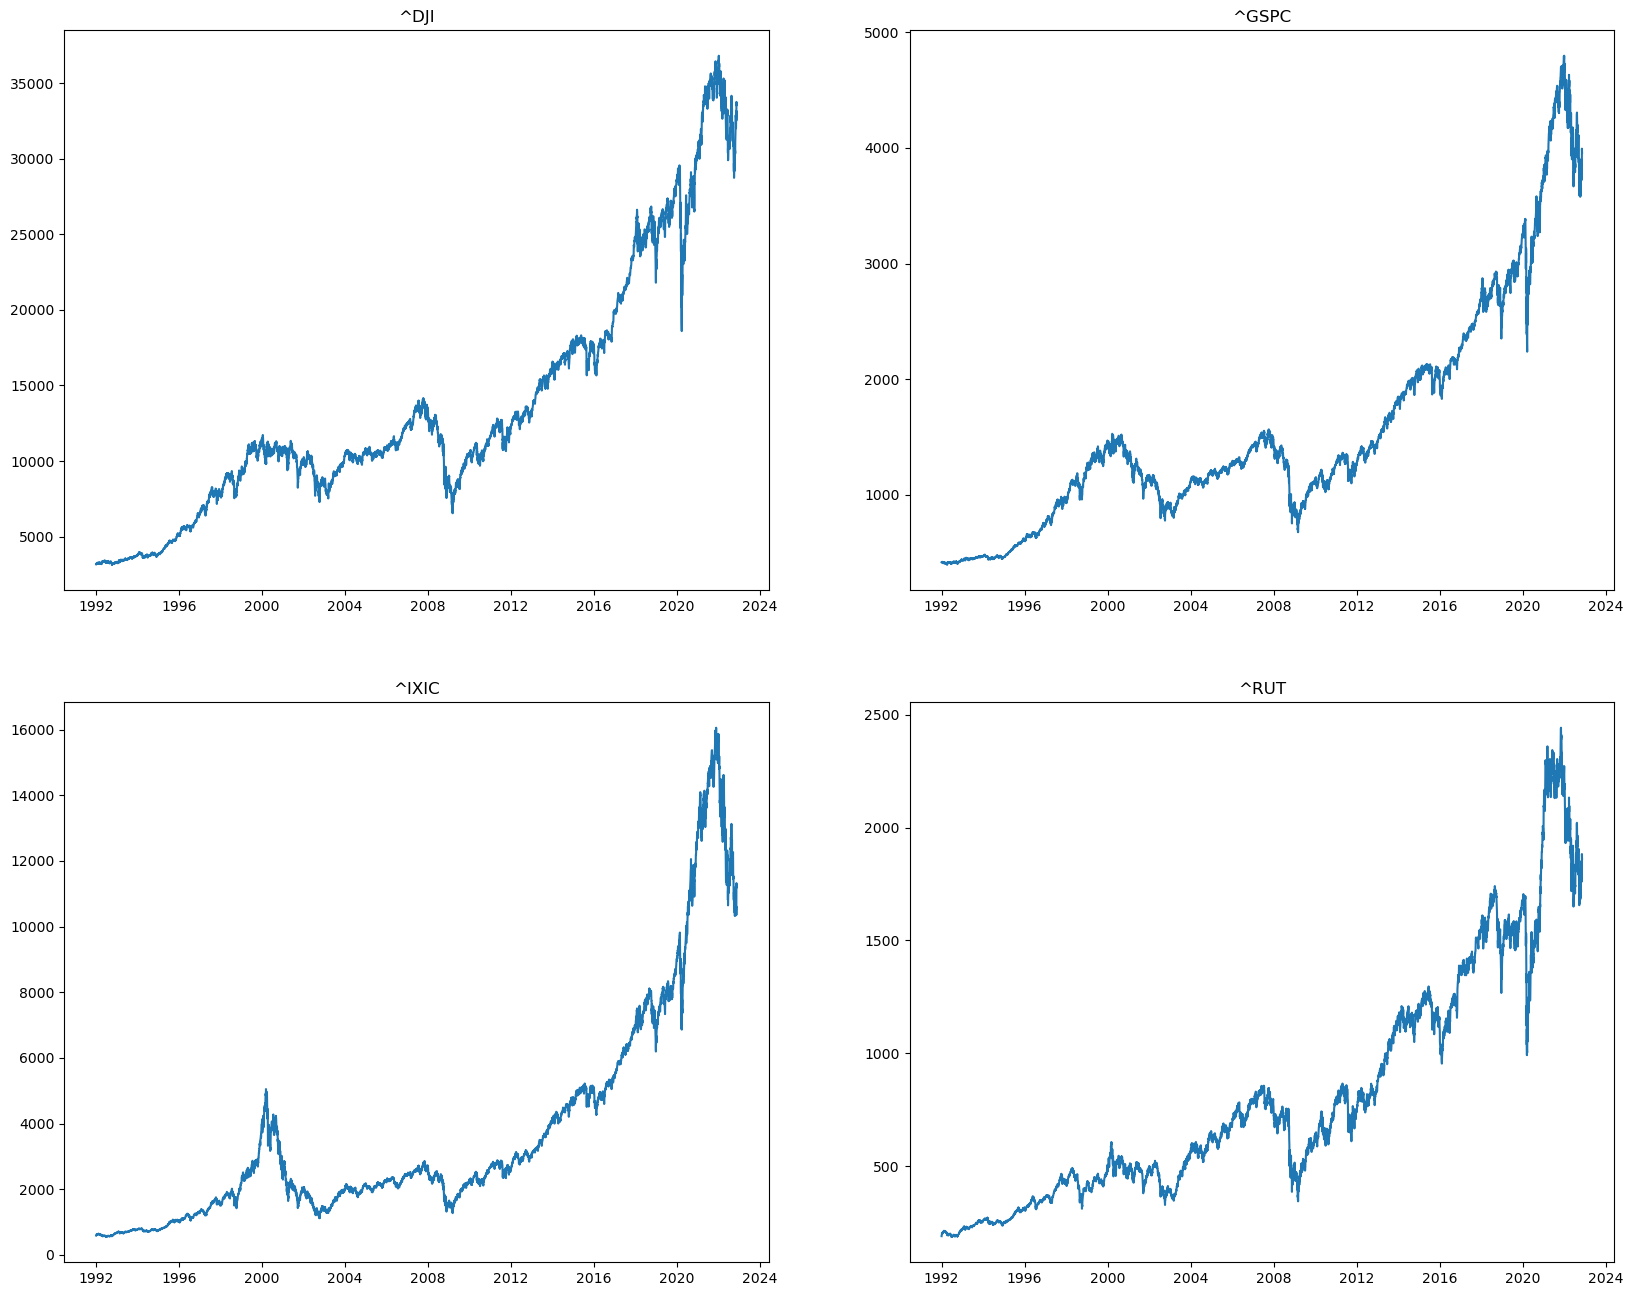

In [5]:
# Plot the adjusted close of each of the indices
figure(figsize = (20,16))
plt.subplot(2,2,1)
name = '^DJI'
plt.plot(data['Date'], data[name])
plt.title(name)
plt.subplot(2,2,2)
name = '^GSPC'
plt.plot(data['Date'], data[name])
plt.title(name)
plt.subplot(2,2,3)
name = '^IXIC'
plt.plot(data['Date'], data[name])
plt.title(name)
plt.subplot(2,2,4)
name = '^RUT'
plt.plot(data['Date'], data[name])
plt.title(name)
plt.show()

In [6]:
# Calculate log returns
data['DJI Return'] = np.log(data['^DJI']) - np.log(data['^DJI'].shift(1))
data['GSPC Return'] = np.log(data['^GSPC']) - np.log(data['^GSPC'].shift(1))
data['IXIC Return'] = np.log(data['^IXIC']) - np.log(data['^IXIC'].shift(1))
data['RUT Return'] = np.log(data['^RUT']) - np.log(data['^RUT'].shift(1))

In [7]:
data = data.reset_index().drop('index', axis = 1)
data = data[data['DJI Return'].notna()]
data = data[['Date', 'DJI Return', 'GSPC Return','IXIC Return', 'RUT Return']]

In [8]:
data.head()

,Date,DJI Return,GSPC Return,IXIC Return,RUT Return
1,1992-01-03,0.009131,0.004972,0.010517,0.017541
2,1992-01-06,-0.000437,-0.003296,0.008820,0.011594
3,1992-01-07,0.001468,-0.001341,0.007315,0.007383
4,1992-01-08,-0.000281,0.001676,0.013244,0.011730
5,1992-01-09,0.001746,-0.001173,0.015413,0.012492


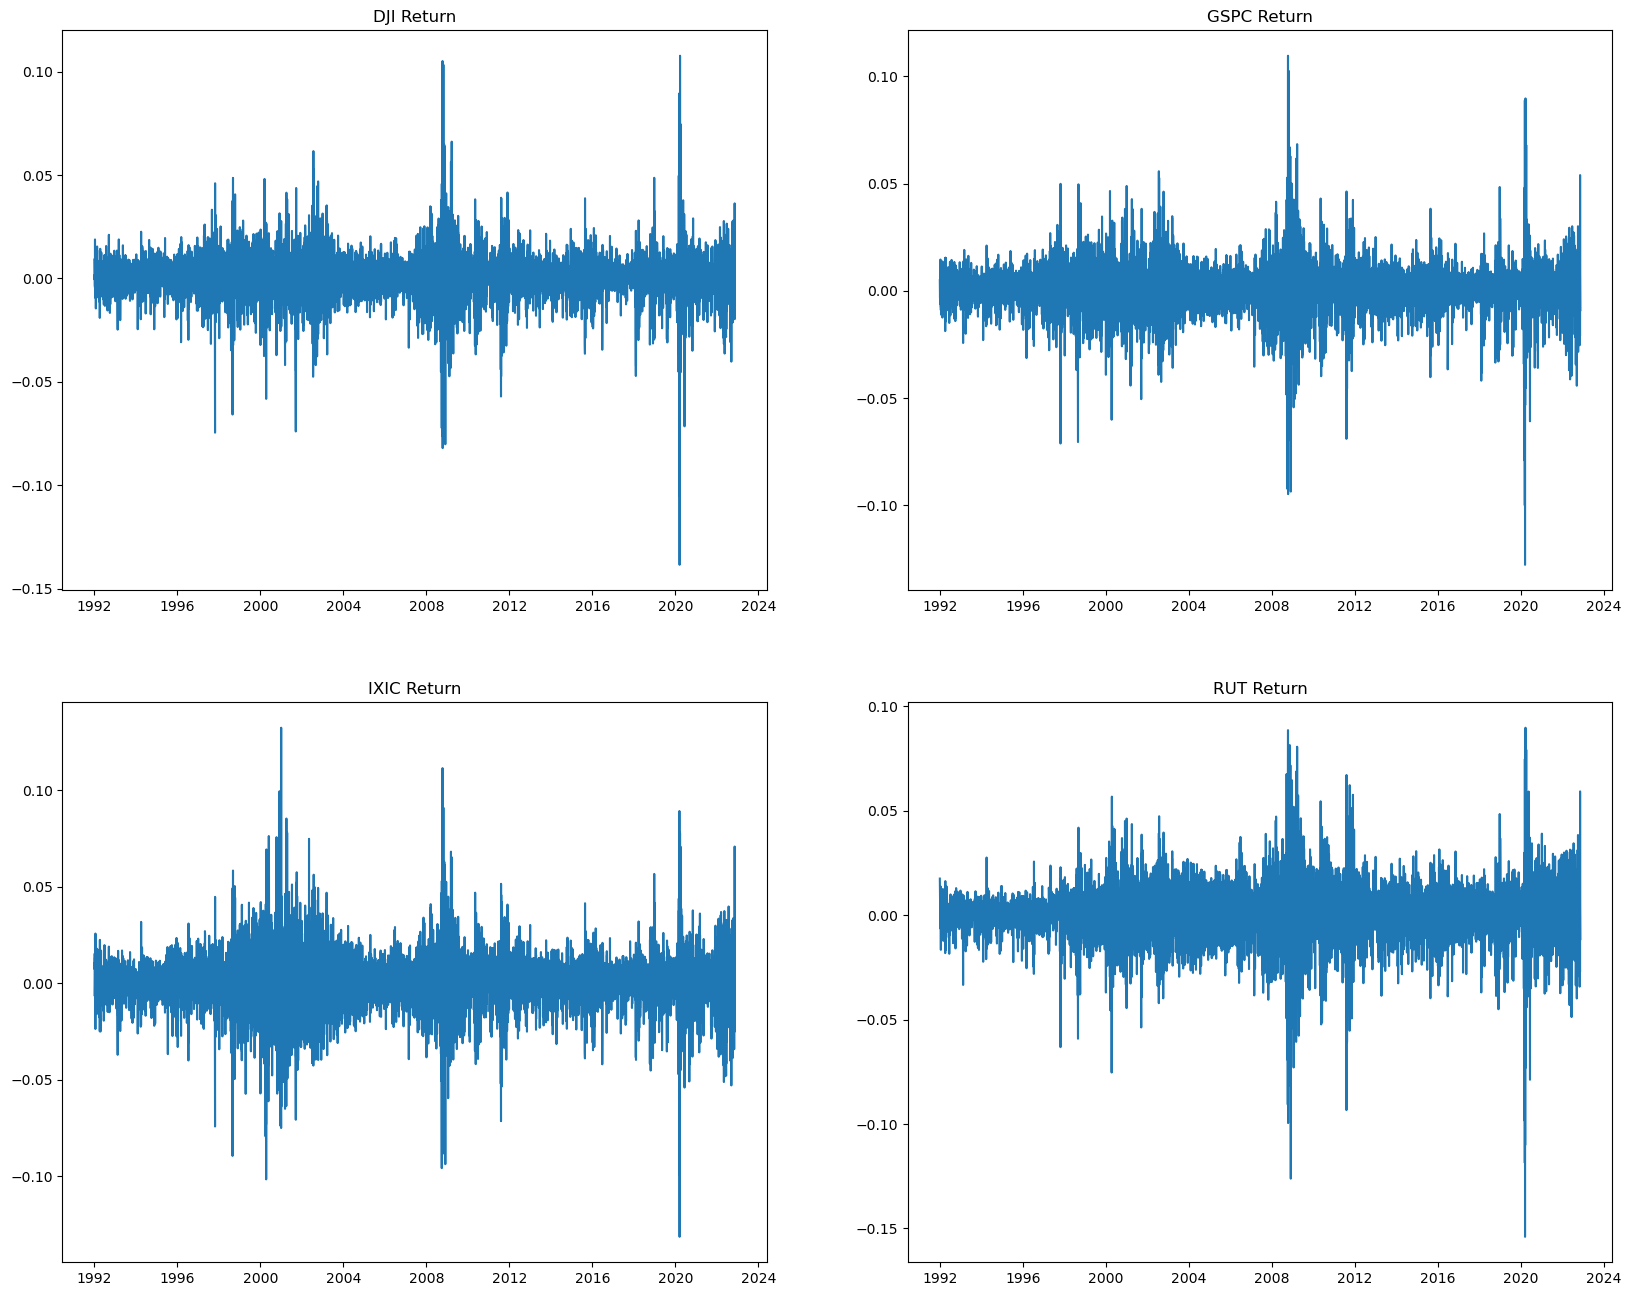

In [9]:
# Plot each of the returns
figure(figsize = (20,16))
plt.subplot(2,2,1)
name = 'DJI Return'
plt.plot(data['Date'], data[name])
plt.title(name)
plt.subplot(2,2,2)
name = 'GSPC Return'
plt.plot(data['Date'], data[name])
plt.title(name)
plt.subplot(2,2,3)
name = 'IXIC Return'
plt.plot(data['Date'], data[name])
plt.title(name)
plt.subplot(2,2,4)
name = 'RUT Return'
plt.plot(data['Date'], data[name])
plt.title(name)
plt.show()

In [10]:
# Calculate the multivariate sliding window of size 50, stride 1, for the returns of the indices
window_size = 50
stride = 1
X = data[['DJI Return', 'GSPC Return','IXIC Return', 'RUT Return']]
y = data['Date']
SW = SlidingWindow(size=window_size, stride=stride)
X_sw, yr = SW.fit_transform_resample(X, y)

In [86]:
# Plot the persistence diagram and landscape for a random point cloud sliding window
from gtda.homology import VietorisRipsPersistence
pointcloud = X_sw[800]

vrp = VietorisRipsPersistence()
vrp.fit_transform_plot(pointcloud.reshape(1, *pointcloud.shape))
plt.show()

pl = PersistenceLandscape(2)
persistencediagram = vrp.fit_transform(pointcloud.reshape(1, *pointcloud.shape))
landscapedata = pl.fit_transform(persistencediagram)
pl.plot(landscapedata, homology_dimensions = [1], plotly_params=None)

In [105]:
# Functions to compute the Lp norms
# Find the range of x values from the persistence diagram:
def Ftseq(diagram):
    births =[]
    deaths =[]
    for pair in diagram:
        if pair[2] == 1:
            births.append(pair[0])
            deaths.append(pair[1])
    return np.linspace(min(births), max(deaths), 100)

# Calculate Lp norm:
def Lpnorm(tseq, landscapevalues, p = 1):
    norms = []
    if p == 'auc':
        layervalues = landscapevalues[layers]
        for point in zip(tseq,layervalues):
            norms.append(np.trapz(layervalues, tseq))
        return(sum(norms))
    elif p == 'aucUpdated':
        layervalues = landscapevalues[layers]
        return (np.trapz(layervalues))
    else:
        normvalues = []
        for layer in range(layers, 2*layers):
            layervalues = landscapevalues[layer]
            normvalue = np.linalg.norm(layervalues,p)**p
            if normvalue == 0:
                break
            else: 
                normvalues.append(normvalue)
        return (np.sum(normvalues)**(1/p))

In [117]:
Lpnorm(tseq, landscapedata[0], p = 'auc')

0.0001070953735798526

In [118]:
Lpnorm(tseq, landscapedata[0], p = 'aucUpdated')

0.01510572701579694

In [119]:
Lpnorm(tseq, landscapedata[0], p = 1)

0.021986343149998876

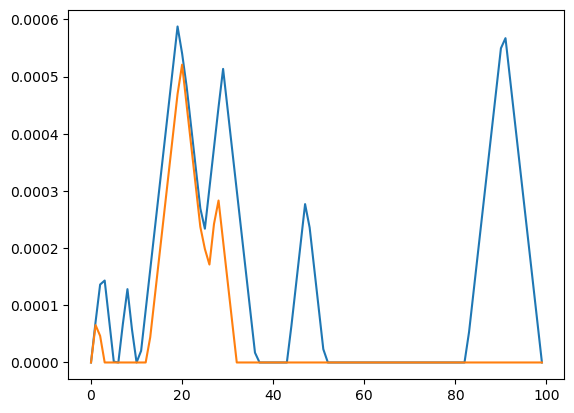

In [85]:
plt.plot(landscapedata[0][layers])
plt.plot(landscapedata[0][layers+1])

In [68]:
landscapedata[0][layers:]

array([[0.00000000e+00, 7.08971991e-05, 1.36303786e-04, 1.43306457e-04,
        7.24092577e-05, 1.51205864e-06, 0.00000000e+00, 6.77900530e-05,
        1.28260066e-04, 5.73628667e-05, 0.00000000e+00, 2.04473423e-05,
        9.13445414e-05, 1.62241741e-04, 2.33138940e-04, 3.04036139e-04,
        3.74933338e-04, 4.45830537e-04, 5.16727736e-04, 5.87624935e-04,
        5.40390851e-04, 4.82078134e-04, 4.11180935e-04, 3.40283735e-04,
        2.69386536e-04, 2.33974491e-04, 3.04871690e-04, 3.75768889e-04,
        4.46666089e-04, 5.13445261e-04, 4.42548062e-04, 3.71650863e-04,
        3.00753664e-04, 2.29856465e-04, 1.58959266e-04, 8.80620668e-05,
        1.71648677e-05, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        6.42632755e-05, 1.35160475e-04, 2.06057674e-04, 2.76954873e-04,
        2.35944690e-04, 1.65047491e-04, 9.41502918e-05, 2.32530927e-05,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.000000

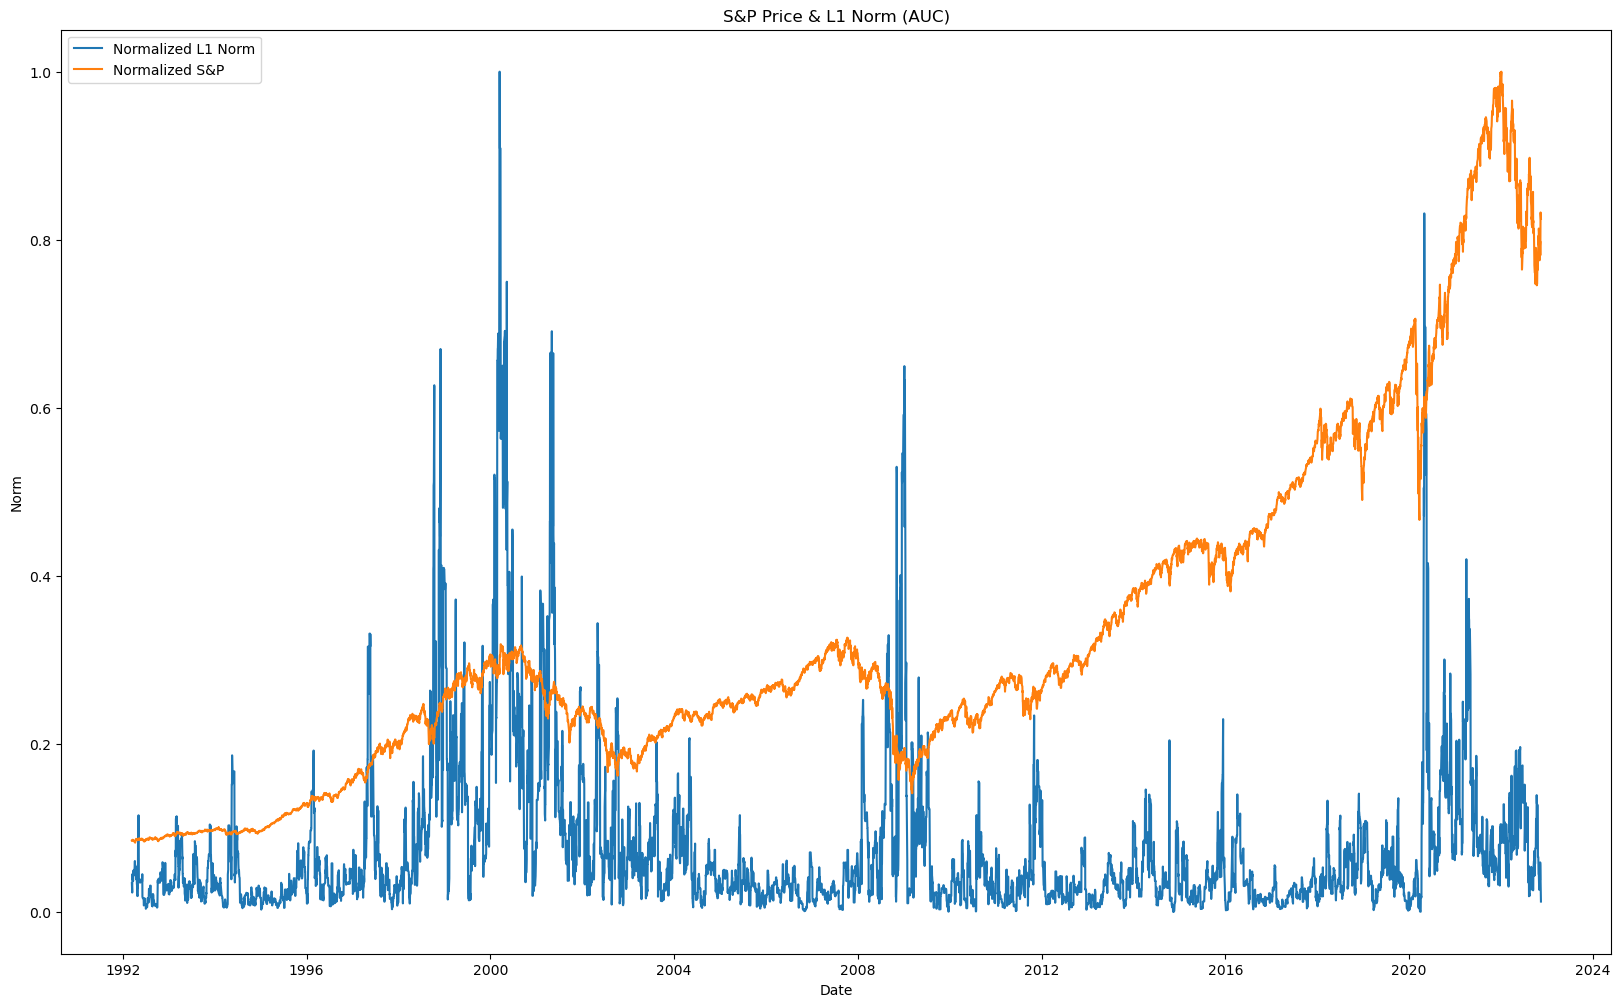

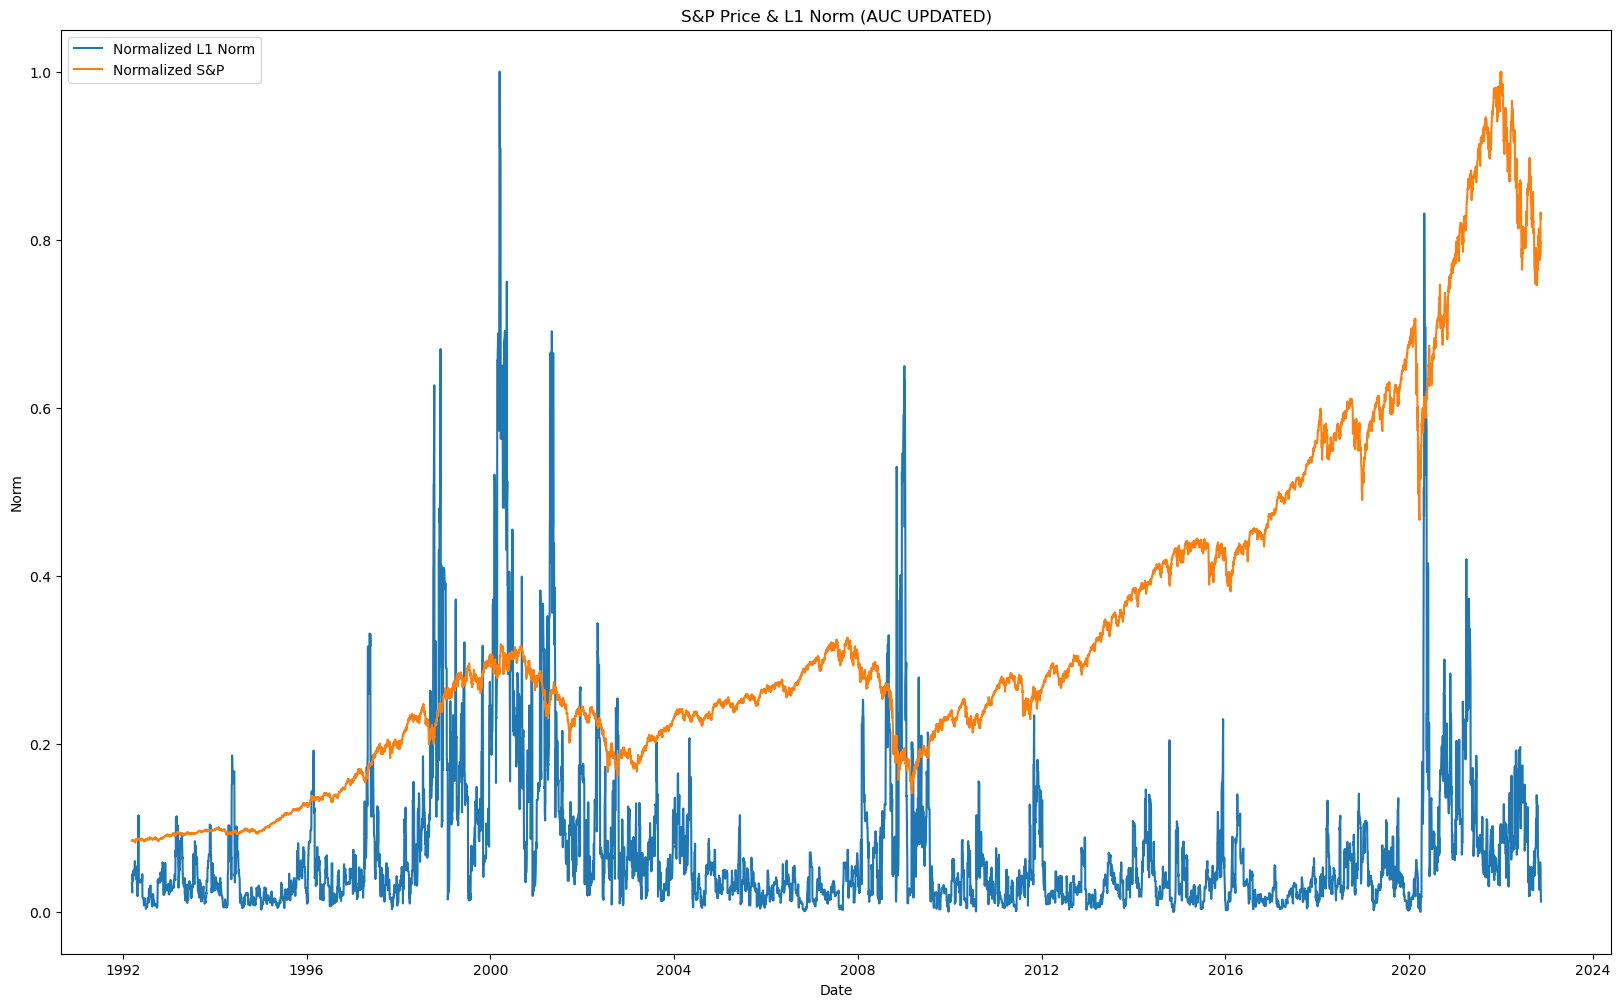

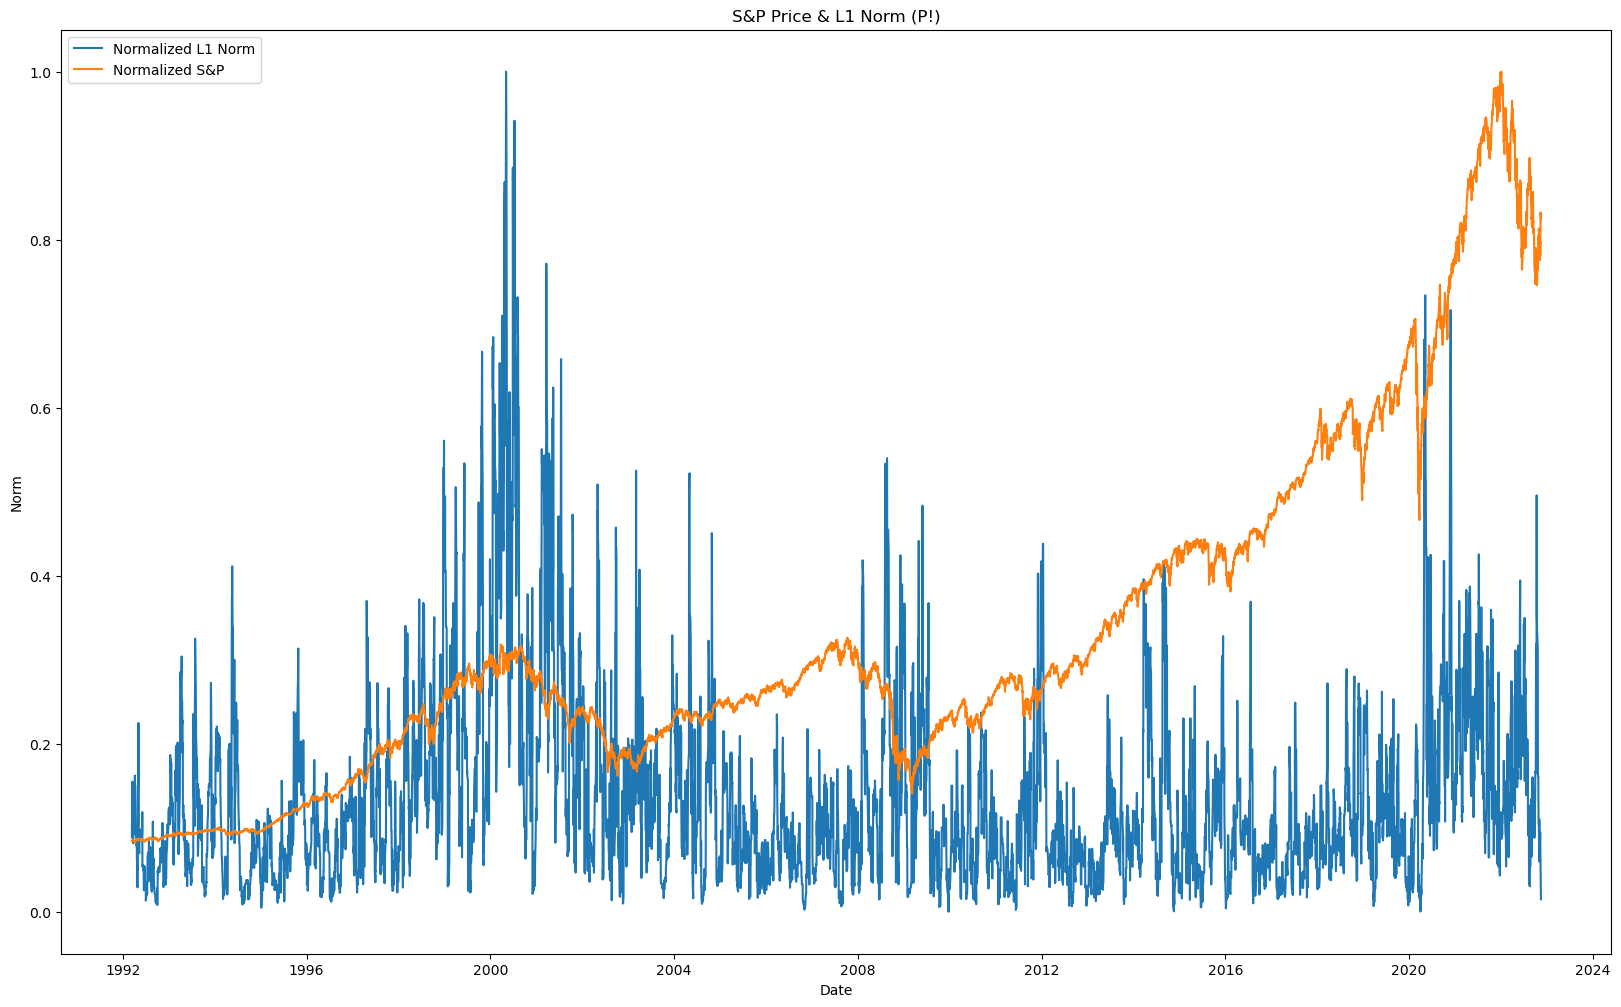

In [120]:
# Calculate the norms for each of the windows in the multivariate sliding window
Normsauc = []
NormsaucUpdated = []
NormsP1 = []

layers = 5
vrp = VietorisRipsPersistence()
pl = PersistenceLandscape(layers)
for pointcloud in X_sw:
    persistencediagram = vrp.fit_transform(pointcloud.reshape(1, *pointcloud.shape))
    landscapedata = pl.fit_transform(persistencediagram)
    tseq = Ftseq(persistencediagram[0])
#     yvalues = landscapedata[0][1]
    Normsauc.append(Lpnorm(tseq, landscapedata[0], p = 'auc'))
    NormsaucUpdated.append(Lpnorm(tseq, landscapedata[0], p = 'auc'))
    NormsP1.append(Lpnorm(tseq, landscapedata[0], p = 1))
    
# Create a dataframe combining the date, norm and price of S&P
timeseriesdataauc = {
    
    'Date': yr,
    'Norm' : Normsauc,
    'S&P': df[df['Date'] >= pd.Timestamp('1992-03-13 00:00:00')]['^GSPC']
}
timeseriesdfauc = pd.DataFrame(timeseriesdataauc)

# Create a dataframe combining the date, norm and price of S&P
timeseriesdataaucUpdated = {
    
    'Date': yr,
    'Norm' : NormsaucUpdated,
    'S&P': df[df['Date'] >= pd.Timestamp('1992-03-13 00:00:00')]['^GSPC']
}
timeseriesdfaucUpdated = pd.DataFrame(timeseriesdataaucUpdated)

# Create a dataframe combining the date, norm and price of S&P
timeseriesdataP1 = {
    
    'Date': yr,
    'Norm' : NormsP1,
    'S&P': df[df['Date'] >= pd.Timestamp('1992-03-13 00:00:00')]['^GSPC']
}
timeseriesdfP1 = pd.DataFrame(timeseriesdataP1)


#Plot the full date range for the S&P and norms
figure(figsize = (20,12))
sns.lineplot(x = timeseriesdfauc['Date'] , y = timeseriesdfauc['Norm']/timeseriesdfauc['Norm'].max(), label = 'Normalized L1 Norm')
sns.lineplot(x = timeseriesdfauc['Date'], y =timeseriesdfauc['S&P']/timeseriesdfauc['S&P'].max(), label = 'Normalized S&P')
plt.title('S&P Price & L1 Norm (AUC)')
plt.show()


figure(figsize = (20,12))
sns.lineplot(x = timeseriesdfaucUpdated['Date'] , y = timeseriesdfaucUpdated['Norm']/timeseriesdfaucUpdated['Norm'].max(), label = 'Normalized L1 Norm')
sns.lineplot(x = timeseriesdfaucUpdated['Date'], y =timeseriesdfaucUpdated['S&P']/timeseriesdfaucUpdated['S&P'].max(), label = 'Normalized S&P')
plt.title('S&P Price & L1 Norm (AUC UPDATED)')
plt.show()

figure(figsize = (20,12))
sns.lineplot(x = timeseriesdfP1['Date'] , y = timeseriesdfP1['Norm']/timeseriesdfP1['Norm'].max(), label = 'Normalized L1 Norm')
sns.lineplot(x = timeseriesdfP1['Date'], y =timeseriesdfP1['S&P']/timeseriesdfP1['S&P'].max(), label = 'Normalized S&P')
plt.title('S&P Price & L1 Norm (P!)')
plt.show()

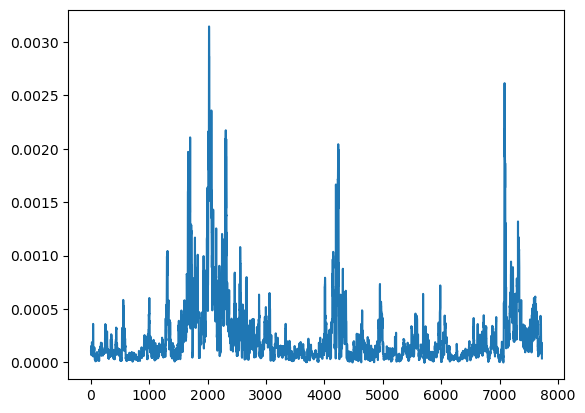

In [35]:
plt.plot(Normsauc)

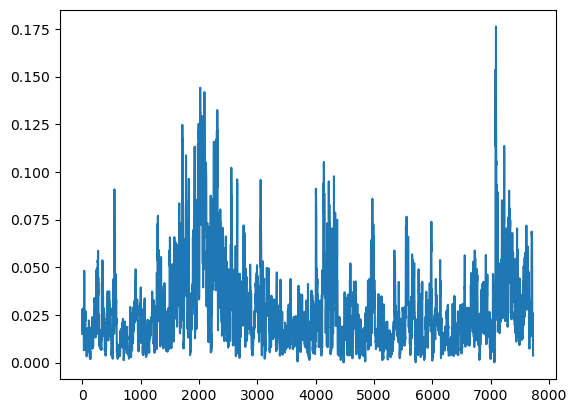

In [37]:
plt.plot(NormsaucUpdated)

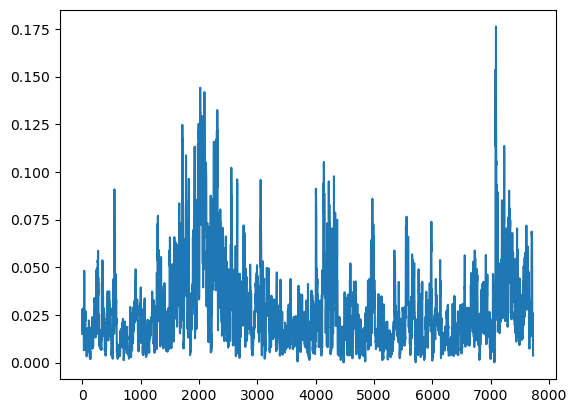

In [38]:
plt.plot(NormsP1)

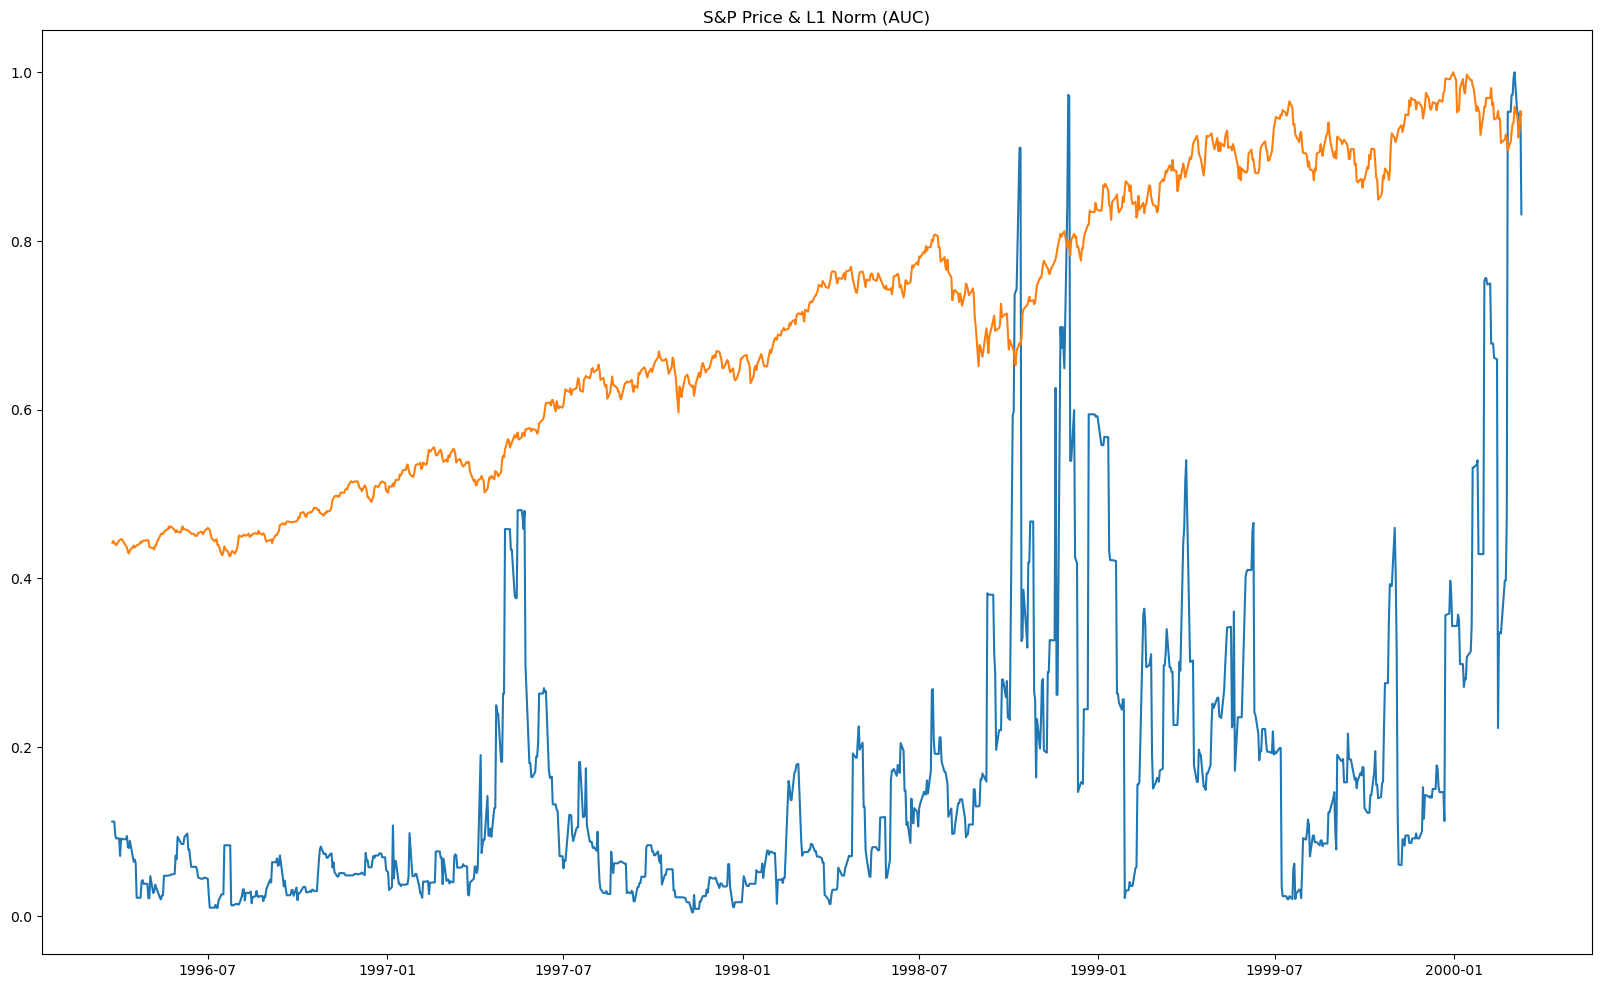

NameError: name 'speriodogram' is not defined

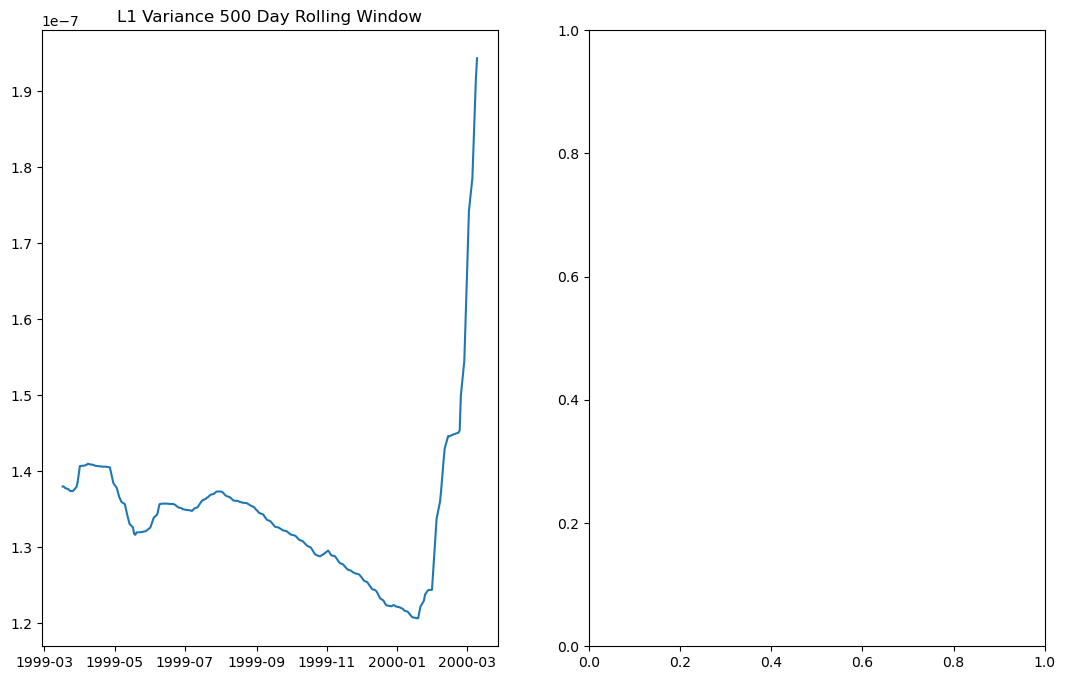

In [16]:
# Plot the 1000 days leading to the dotcom crash

dotcomIndex = timeseriesdf[timeseriesdf['Date'] == pd.Timestamp('2000-03-10 00:00:00')].index[0]
# dotcomIndex = timeseriesdf[timeseriesdf['Date'] == pd.Timestamp('2000-07-03 00:00:00')].index[0]

dotcomdf = timeseriesdf.loc[dotcomIndex - 1000: dotcomIndex, :]
figure(figsize = (20,12))
plt.plot()
plt.plot(dotcomdf['Date'] , dotcomdf['Norm']/dotcomdf['Norm'].max())
plt.plot(dotcomdf['Date'], dotcomdf['S&P']/dotcomdf['S&P'].max() )
plt.title('S&P Price & L1 Norm (AUC)')
plt.show()


figure(figsize = (20,8))
plt.subplot(1,3,1)
plt.plot(dotcomdf['Date'].tail(250), dotcomdf.rolling(window = 500).var()['Norm'].tail(250))
plt.title('L1 Variance 500 Day Rolling Window')

plt.subplot(1,3,2)
# Take mean of power spectrum of x.

avgspec = dotcomdf['Norm'].rolling(window = 500).apply(lambda x: np.mean(speriodogram(x)[:60]))

plt.plot(dotcomdf['Date'].tail(250), avgspec.tail(250))
plt.title('Average Spectral')


plt.subplot(1,3,3)
plt.plot(dotcomdf['Date'].tail(250), dotcomdf['Norm'].rolling(window = 500).corr(dotcomdf['Norm'].shift(1)).tail(250))
plt.title('ACF Lag 1')
plt.show()

## Lehman Crash

In [ ]:
lehmanIndex = timeseriesdf[timeseriesdf['Date'] == pd.Timestamp('2008-9-15 00:00:00')].index[0]
lehmandf = timeseriesdf.loc[lehmanIndex - 1000: lehmanIndex, :]
figure(figsize = (20,12))
plt.plot()
plt.plot(lehmandf['Date'] , lehmandf['Norm']/lehmandf['Norm'].max() , label = 'Normalized L1 Norm')
plt.plot(lehmandf['Date'], lehmandf['S&P']/lehmandf['S&P'].max(),  label = 'Normalized S&P')
plt.title('S&P Price & L1 Norm (AUC)')
plt.show()


figure(figsize = (20,8))
plt.subplot(1,3,1)
# Will have to do it backwards, here doing it forwards
plt.plot(lehmandf['Date'].tail(250), lehmandf.rolling(window = 500).var()['Norm'].tail(250))
plt.title('L1 Variance 500 Day Rolling Window')

plt.subplot(1,3,2)
avgspec = lehmandf['Norm'].rolling(window = 500).apply(lambda x: np.mean(speriodogram(x)[:60]))
plt.plot(lehmandf['Date'].tail(250), avgspec.tail(250))
plt.title('Average Spectral')

plt.subplot(1,3,3)
plt.plot(lehmandf['Date'].tail(250), lehmandf['Norm'].rolling(window = 500).corr(lehmandf['Norm'].shift(1)).tail(250))
plt.title('ACF Lag 1')


plt.show()

## Corona Crash

In [ ]:
coronaIndex = timeseriesdf[timeseriesdf['Date'] == pd.Timestamp('2020-05-20 00:00:00')].index[0]
coronadf = timeseriesdf.loc[coronaIndex - 1000: coronaIndex, :]
figure(figsize = (20,12))
plt.plot()
plt.plot(coronadf['Date'] , coronadf['Norm']/coronadf['Norm'].max())
plt.plot(coronadf['Date'], coronadf['S&P']/coronadf['S&P'].max() )
plt.title('S&P Price & L1 Norm')
plt.show()

figure(figsize = (20,8))
plt.subplot(1,3,1)
plt.plot(coronadf['Date'].tail(250), coronadf.rolling(window = 500).var()['Norm'].tail(250))
plt.title('L1 Variance 500 Day Rolling Window')

plt.subplot(1,3,2)
avgspec = coronadf['Norm'].rolling(window = 500).apply(lambda x: np.mean(speriodogram(x)[:60]))
plt.plot(coronadf['Date'].tail(250), avgspec.tail(250))
plt.title('Average Spectral')

plt.subplot(1,3,3)
plt.plot(coronadf['Date'].tail(250), coronadf['Norm'].rolling(window = 500).corr(coronadf['Norm'].shift(1)).tail(250))
plt.title('ACF Lag 1')


plt.show()